In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run3a_NE_305stop.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

#loss_file = ROOT.TFile.Open("LostMuonsSpectra.root")
#direc = loss_file.Get("Run3a")
#hlm = ROOT.TH1F()
#hlm = direc.Get("triple_losses_spectra_integral")

#loss_file_2 = ROOT.TFile.Open("reconEmuonloss.root")
#direc = loss_file.Get("Run3a")
#hlm_2 = ROOT.TH1D()
#hlm_2 = loss_file_2.Get("lambda3A")

In [3]:
loss_file = ROOT.TFile.Open("reconWmuonloss3a_mod.root")
hlm = ROOT.TH1F()
hlm = loss_file.Get("hI")

loss_file_2 = ROOT.TFile.Open("reconEmuonloss3a_mod.root")
hlm_2 = ROOT.TH1F()
hlm_2 = loss_file_2.Get("hI")

In [4]:
hlm.Scale(1.0/hlm.GetBinContent(hlm.GetNbinsX()))
hlm_2.Scale(1.0/hlm_2.GetBinContent(hlm_2.GetNbinsX()))

In [5]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [6]:
fit_start=30000
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)
x_mloss=np.empty(fit_range)
y_mloss=np.empty(fit_range)
x_mloss_2=np.empty(fit_range)
y_mloss_2=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))
    x_mloss[ibin]=hlm.GetBinCenter(ibin+hlm.FindBin(fit_start))
    y_mloss[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start))
    x_mloss_2[ibin]=hlm_2.GetBinCenter(ibin+hlm_2.FindBin(fit_start))
    y_mloss_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [7]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

3.1864095276718523e-09


In [8]:
y_mlossf=np.empty(fit_range)
y_mlossb=np.empty(fit_range)

y_mlossf_2=np.empty(fit_range)
y_mlossb_2=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_mlossf[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start)+nbinshift)
    y_mlossb[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start)-nbinshift) 
    y_mlossf_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start)+nbinshift)
    y_mlossb_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start)-nbinshift)

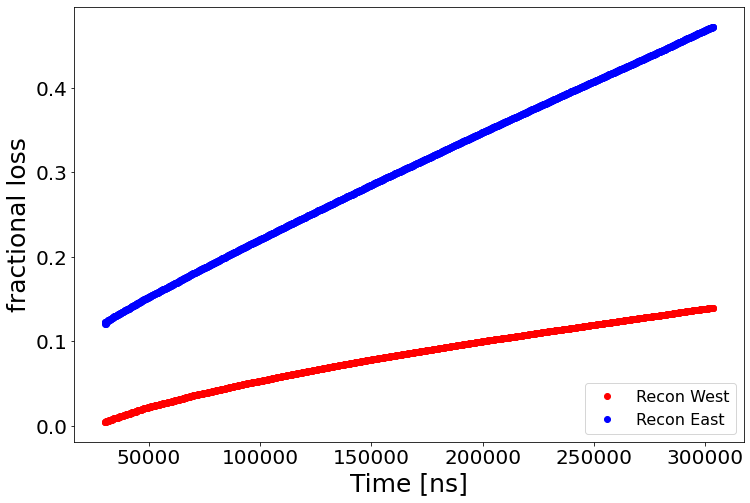

In [10]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.scatter(x_mloss_2, y_mloss_2, s=0.9, color='red', label='Data')
plt.errorbar(x_mloss, y_mloss, color='red', fmt="o", label='Recon West')
#plt.scatter(x_mloss, y_mlossf, s=0.9, color='black', label='Data')
#plt.scatter(x_mloss, y_mlossb, s=0.9, color='red', label='Data')
plt.errorbar(x_mloss_2, y_mloss_2, color='blue', fmt = "o", label='Recon East')
#plt.scatter(x_mloss_2, y_mlossf_2, s=0.9, color='orange', label='Data')
#plt.scatter(x_mloss_2, y_mlossb_2, s=0.9, color='gray', label='Data')
#plt.plot(x_val, fit, linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('fractional loss',fontsize=25)
plt.legend(loc=4, prop={'size': 16})
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [10]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             A_cbot = 0.0,
             tau_cbot = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0)-> np.double:
    
    tau_cbovw = 17680
    omega_cbovw = 0.012
    
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw - ff*Ncbof*Nvwf*Nvbof*Ncbovwf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw + ff*Ncbof*Nvwf*Nvbof*Ncbovwf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb)

In [11]:
def fit_func_RE(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             A_cbot = 0.0,
             tau_cbot = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0)-> np.double:
    
    tau_cbovw = 17680,
    omega_cbovw = 0.012,
    
    A_lm = 0.00154
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Nloss = (1 - A_lm * y_mloss_2)
    Nlossf = (1 - A_lm * y_mlossf_2) 
    Nlossb = (1 - A_lm * y_mlossb_2)

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss - ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss + ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)

In [12]:
def fit_func_RW(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             A_cbot = 0.0,
             tau_cbot = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0)-> np.double:
    
    tau_cbovw = 17680,
    omega_cbovw = 0.012,
    
    A_lm = 0.00996
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Nloss = (1 - A_lm * y_mloss)
    Nlossf = (1 - A_lm * y_mlossf) 
    Nlossb = (1 - A_lm * y_mlossb)

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss - ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss + ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)

In [13]:
p_init=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.330e-03,
        5.56481e-01,
        6.91318e-04,
        5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        1.38419e+05,
        1.389e-02,
        2.734e-01,
        1.0011e-03,
        3.482e+04,
        1.407e-02,
        5.22,
        1.106e-04,
        3.07e+00,
        3.7000e+08,
        0.005,
        23100,
        0.0001,
        4.2]

In [14]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [15]:
p_init=pars2

In [16]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [17]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [18]:
for ipar in range(0,26):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.22941224698402682        +-   1.3158858970714058e-05   

-35.30772877879309        +-   0.38461359420736624   

4.023100803632922        +-   5.863947682658376e-05   

0.0018688949814595459        +-   2.020658904226347e-05   

230607.9619455481        +-   7107.3149766124   

0.0023296303360930337        +-   4.4584844538476864e-07   

-0.3451023832478709        +-   0.0754315667768977   

0.0003998665836791597        +-   6.0772650709001154e-05   

6.019285348003201        +-   0.16694955996576363   

-7.795833228099798e-05        +-   6.18166326093868e-05   

35.219672172873764        +-   0.7842620719545035   

0.00047556564714485014        +-   3.5913884421097135e-05   

85310.68848298462        +-   8404.365209753314   

0.013891676891909911        +-   1.1513577083541472e-06   

-0.293086688176598        +-   0.07513354402590369   

-0.0041982182213576545        +-   0.0006577195976404241   

15470.066090869374        +-   1008.9392732477885   

0.014099668055756633        +- 

Text(0, 0.5, 'FFT Mag [arb. units]')

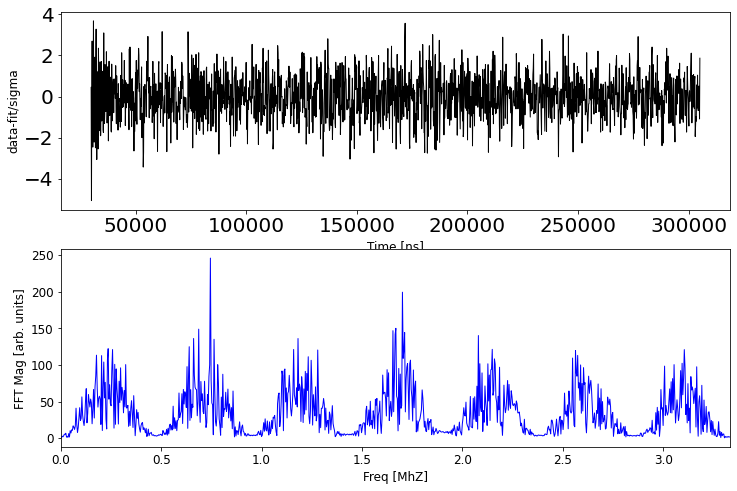

In [19]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err
fou=abs(np.fft.fft(res))
#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)
# Plot the noisy exponential data

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=12)
plt.ylabel('data-fit/sigma',fontsize=12)
#plt.savefig('run2all_res.jpg')

plt.subplot(212)
#plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=12)
plt.ylabel('FFT Mag [arb. units]',fontsize=12)
#plt.savefig('run2all_fft.jpg')

In [20]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))
ndf=fit_range-len(pars_final)
red_chi2=chi2/ndf
red_chi2

1.0232713061779724

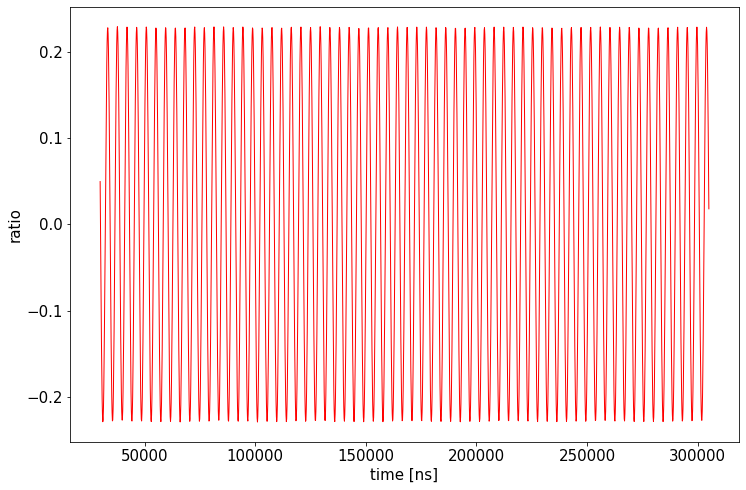

In [21]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('ratio',fontsize=15)
plt.show()

In [22]:
p_init_RE=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.330e-03,
        5.56481e-01,
        6.91318e-04,
        5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        1.38419e+05,
        1.389e-02,
        2.734e-01,
        1.0011e-03,
        3.482e+04,
        1.407e-02,
        5.22,
        1.106e-04,
        3.07e+00,
        3.7000e+08,
        0.005,
        23100,
        0.0001,
        4.2]

In [23]:
pars2_RE, cov2_RE = opt.curve_fit(f=fit_func_RE, xdata=x_val, ydata=y_val, p0=p_init_RE, sigma=y_err)

In [24]:
p_init_RE=pars2_RE

In [25]:
pars_final_RE, cov_final_RE = opt.curve_fit(f=fit_func_RE, xdata=x_val, ydata=y_val, p0=p_init_RE, sigma=y_cov)

In [26]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_RE = np.sqrt(np.diag(cov_final_RE))

In [27]:
for ipar in range(0,26):
    print(pars_final_RE[ipar],"       +-  ",stdevs_RE[ipar],"  \n")

0.22941240104194682        +-   1.3158784408157406e-05   

-35.307746125922485        +-   0.38460902659690027   

4.023101701718278        +-   5.8638335632374164e-05   

0.0018690122399627424        +-   2.020804828966394e-05   

230587.7609849673        +-   7106.402515772197   

0.0023296277361652814        +-   4.4449957560456234e-07   

-0.34558393583361363        +-   0.07508181785327113   

0.00039931969649104553        +-   6.077194398986066e-05   

6.018981279157883        +-   0.16697424189730173   

-7.738471761457989e-05        +-   6.185332928023405e-05   

35.210187883917506        +-   0.7893569526956686   

0.0004754790669159823        +-   3.5908482738303476e-05   

85327.2698381054        +-   8406.947397329   

0.013891676327295568        +-   1.1512280612380734e-06   

-0.29313480474662795        +-   0.07512797597355476   

-0.00419864359523005        +-   0.0006577536994951821   

15469.616155780106        +-   1008.8203810794029   

0.01409965678340544        +-

Text(0, 0.5, 'FFT Mag [arb. units]')

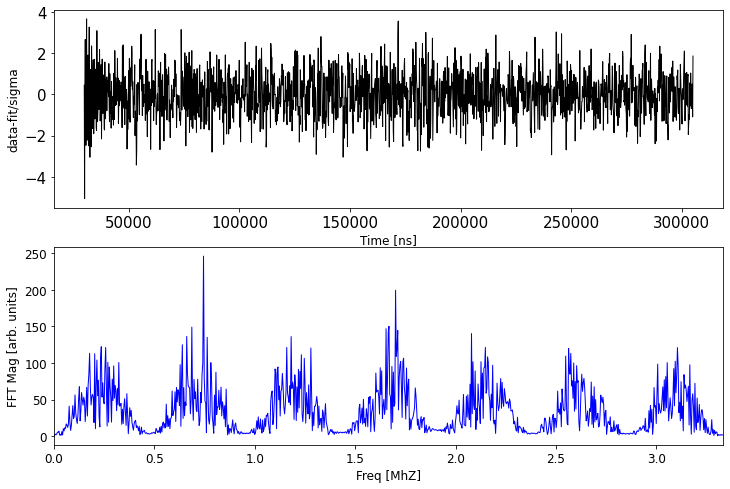

In [28]:
# Calculate the residuals
res_RE = (y_val - fit_func_RE(x_val, *pars_final_RE))/y_err
fou_RE=abs(np.fft.fft(res_RE))
#xfft=np.empty(fit_range)
xfft_RE= np.linspace(0,6.667,num=fit_range)
# Plot the noisy exponential data

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(x_val, res_RE, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=12)
plt.ylabel('data-fit/sigma',fontsize=12)
#plt.savefig('run2all_res.jpg')

plt.subplot(212)
#plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(xfft, fou_RE, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=12)
plt.ylabel('FFT Mag [arb. units]',fontsize=12)
#plt.savefig('run2all_fft.jpg')

In [29]:
chi2_RE=np.dot((np.transpose(y_val-fit_func_RE(x_val, *pars_final_RE))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func_RE(x_val, *pars_final_RE)))))
ndf_RE=fit_range-len(pars_final_RE)
red_chi2_RE=chi2_RE/ndf
red_chi2_RE

1.023256607237168

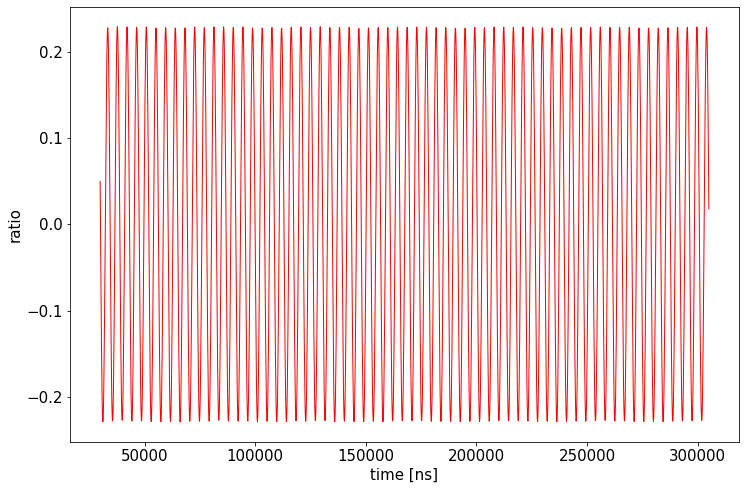

In [30]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, fit_func_RE(x_val, *pars_final_RE), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('ratio',fontsize=15)
plt.show()

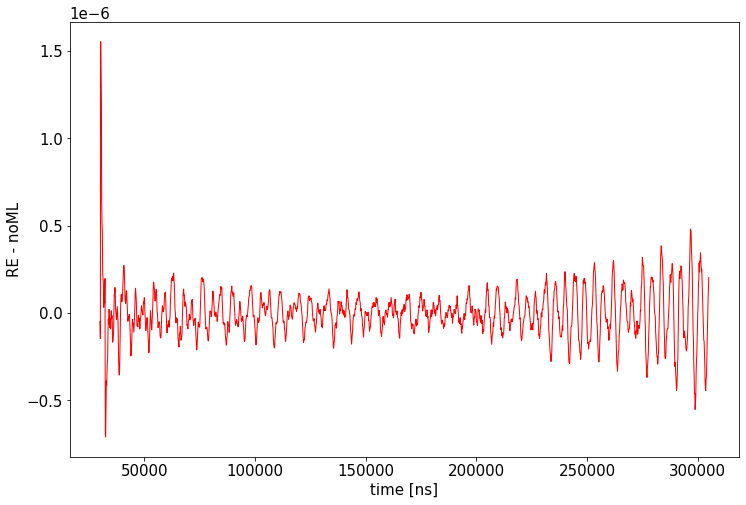

In [31]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, (fit_func_RE(x_val, *pars_final_RE))-(fit_func(x_val, *pars_final)), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('RE - noML',fontsize=15)
#plt.ylim(0.99998,1.00002)
#plt.xlim(29000,40000)
plt.show()

In [32]:
p_init_RW=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.330e-03,
        5.56481e-01,
        6.91318e-04,
        5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        1.38419e+05,
        1.389e-02,
        2.734e-01,
        1.0011e-03,
        3.482e+04,
        1.407e-02,
        5.22,
        1.106e-04,
        3.07e+00,
        3.7000e+08,
        0.005,
        23100,
        0.0001,
        4.2]

In [33]:
pars2_RW, cov2_RW = opt.curve_fit(f=fit_func_RW, xdata=x_val, ydata=y_val, p0=p_init_RW, sigma=y_err)

In [34]:
p_init_RW=pars2_RW

In [35]:
pars_final_RW, cov_final_RW = opt.curve_fit(f=fit_func_RW, xdata=x_val, ydata=y_val, p0=p_init_RW, sigma=y_cov)

In [36]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_RW = np.sqrt(np.diag(cov_final_RW))

In [37]:
for ipar in range(0,26):
    print(pars_final_RW[ipar],"       +-  ",stdevs_RW[ipar],"  \n")

0.22941224961266468        +-   1.3161750128304844e-05   

-35.2977323252824        +-   0.3847968001745782   

4.023103457969269        +-   5.865021859941225e-05   

0.0018693842824503888        +-   2.0213180908393983e-05   

230555.25421878212        +-   7104.9702077190805   

0.002329635150059543        +-   4.482540520661978e-07   

-0.3436616212808601        +-   0.07604392739975682   

0.00039917138540789324        +-   6.078825822580467e-05   

6.017837403755033        +-   0.16747671815313817   

-7.728847269232782e-05        +-   6.188395321180637e-05   

35.217698545755844        +-   0.7913452098544073   

0.0004755998862756523        +-   3.592420772467537e-05   

85304.43597282073        +-   8405.117919384667   

0.013891672652520497        +-   1.1515858571243177e-06   

-0.29334492046053423        +-   0.07514467765032146   

-0.004199559924628486        +-   0.0006580590757041227   

15468.132235548757        +-   1008.9210528324203   

0.014099668286538436        +

Text(0, 0.5, 'FFT Mag [arb. units]')

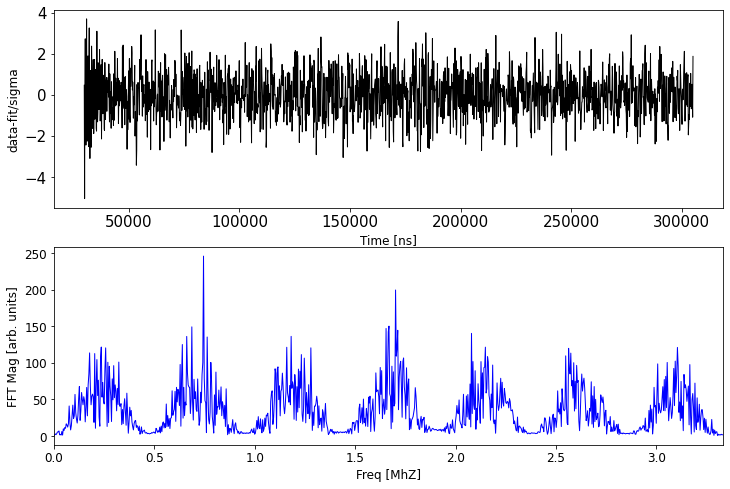

In [38]:
# Calculate the residuals
res_RW = (y_val - fit_func_RW(x_val, *pars_final_RW))/y_err
fou_RW=abs(np.fft.fft(res_RW))
#xfft=np.empty(fit_range)
xfft_RW= np.linspace(0,6.667,num=fit_range)
# Plot the noisy exponential data

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(x_val, res_RW, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=12)
plt.ylabel('data-fit/sigma',fontsize=12)
#plt.savefig('run2all_res.jpg')

plt.subplot(212)
#plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(xfft, fou_RW, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=12)
plt.ylabel('FFT Mag [arb. units]',fontsize=12)
#plt.savefig('run2all_fft.jpg')

In [39]:
chi2_RW=np.dot((np.transpose(y_val-fit_func_RW(x_val, *pars_final_RW))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func_RW(x_val, *pars_final_RW)))))
ndf_RW=fit_range-len(pars_final_RW)
red_chi2_RW=chi2_RW/ndf
red_chi2_RW

1.0236944243695294

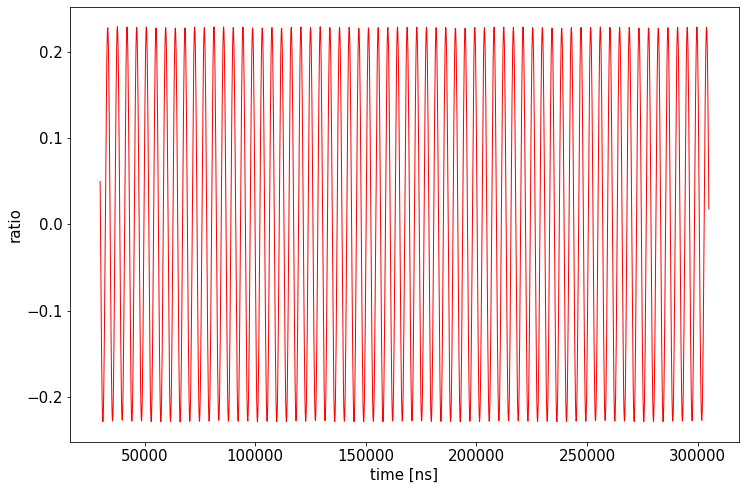

In [40]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, fit_func_RW(x_val, *pars_final_RW), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('ratio',fontsize=15)
plt.show()

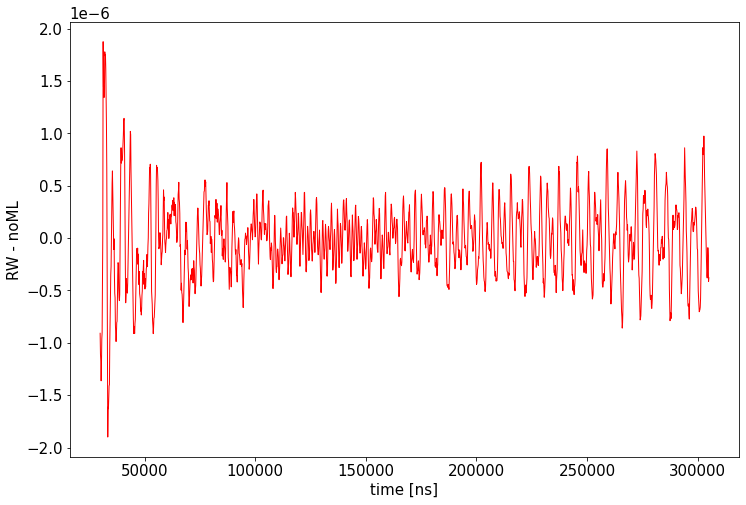

In [41]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, (fit_func_RW(x_val, *pars_final_RW))-(fit_func(x_val, *pars_final)), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('RW - noML',fontsize=15)
#plt.ylim(0.99998,1.00002)
#plt.xlim(29000,40000)
plt.show()

In [42]:
pars_final_RE[1]-pars_final[1]

-1.7347129393385785e-05

In [43]:
pars_final_RW[1]-pars_final[1]

0.009996453510694892